# 03.07. LLM-Based Hypothesis Generation💡

📍 [Download notebook and session files](https://github.com/maxschmaltz/Course-LLM-based-Assistants/tree/main/llm-based-assistants/sessions/block2_core_topics/pt2_science/0307)

In today's lab session, we'll implement and explore different LLM-based approaches for scientific hypothesis generation. Building on the concepts from our [lecture](../../pt2_science/0107.md), we'll work with synthetical social science data to generate, refine, and qualitatively evaluate hypotheses about dependency of educational outcomes from socioeconomic factors.

Our plan for today:

* [Data Preparation](#data)
* [Strategy 1: Straightforward Application](#straightforward)
* [Strategy 2: Literature-Conditioned Generation](#lit)
* [Strategy 3: Cross-Domain Analogy Generation](#xdom)
* [Strategy 4: Contradiction-Based Generation](#contra)
* [Iterative Refinement (Mini-HypoGeniC)](#iter)

## Prerequisites

To start with the tutorial, complete the steps [Prerequisites](../../../infos/llm_inference_guide/README.md#prerequisites), [Environment Setup](../../../infos/llm_inference_guide/README.md#environment-setup), and [Getting API Key](../../../infos/llm_inference_guide/README.md#getting-api-key) from the [LLM Inference Guide](../../../../infos/llm_inference_guide/README.md).

Today, we have more packages so we'll use the requirements file to install the dependencies:

```
pip install -r requirements.txt
```

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.rate_limiters import InMemoryRateLimiter

In [2]:
# read system variables
import os
import dotenv

dotenv.load_dotenv()    # that loads the .env file variables into os.environ

True

In [3]:
# choose any model, catalogue is available under https://build.nvidia.com/models
MODEL_NAME = "qwen/qwq-32b"

# this rate limiter will ensure we do not exceed the rate limit
# of 40 RPM given by NVIDIA
rate_limiter = InMemoryRateLimiter(
    requests_per_second=30 / 60,  # 30 requests per minute to be sure
    check_every_n_seconds=0.1,  # wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=4,  # controls the maximum burst size
)

llm = ChatNVIDIA(
    model=MODEL_NAME,
    api_key=os.getenv("NVIDIA_API_KEY"), 
    temperature=0.5,   # warm up this time
    rate_limiter=rate_limiter  # bind the rate limiter
)

/Users/maksimshmalts/Documents/Course-LLM-based-Assistants/llm-based-assistants/sessions/block2_core_topics/pt2_science/0307/.venv/lib/python3.12/site-packages/langchain_nvidia_ai_endpoints/_common.py:217: UserWarning: Found qwen/qwq-32b in available_models, but type is unknown and inference may fail.
  warnings.warn(


Since we will be generating hypotheses here, we'll define a structured output for them here to unify their format.

In [4]:
from pydantic import BaseModel, Field

In [49]:
class Hypothesis(BaseModel):
    statement: str = Field(..., description="Complete hypothesis statement in natural language")
    condition: str = Field(..., description="The specific condition where the hypothesis applies")
    outcome: str = Field(..., description="The expected outcome or dependent variable")
    mechanism: str = Field(..., description="Proposed underlying mechanism or explanation")
    confidence: float = Field(..., ge=0, le=10, description="Confidence level from 0-10")


class Hypotheses(BaseModel):
    hypotheses: list[Hypothesis] = Field(..., description="List of generated hypotheses")

    def __str__(self):
        return "\n".join([
            f"{hypothesis.statement} (Confidence: {hypothesis.confidence})"
            for hypothesis in sorted(self.hypotheses, key=lambda x: x.confidence, reverse=True)
        ])
    
    def __len__(self):
        return len(self.hypotheses)

In [50]:
s_llm = llm.with_structured_output(Hypotheses)

/Users/maksimshmalts/Documents/Course-LLM-based-Assistants/llm-based-assistants/sessions/block2_core_topics/pt2_science/0307/.venv/lib/python3.12/site-packages/langchain_nvidia_ai_endpoints/chat_models.py:816: UserWarning: Model 'qwen/qwq-32b' is not known to support structured output. Your output may fail at inference time.
  warnings.warn(


<h2 id="data">1. Data Generation 📕</h2>

To save the time and storage, we will use a toy _synthetic_ dataset that will include various socioeconomic and demographic factors and educational outcome data.

At first, we will just generate some random data from suitable distributions, and then soe synthetic correlations will be added to those.

In [7]:
import numpy as np
np.random.seed(42)  # for reproducibility

In [8]:
N = 1000  # number of students

In [9]:
# generate
data = {
    # int from 1 to 1000
    "student_id": range(1, N + 1),
    # normal distribution with a mean of 72 and a SD of 15;
    # this will mostly cluster around 72 but allow for some variation
    # at both sides
    "math_score": np.random.normal(70, 30, N),
    # normal distribution with a mean of 78 and a SD of 12;
    # this will mostly cluster around 78 but allow for some variation
    # at both sides
    "reading_score": np.random.normal(75, 25, N),
    # one of the three categories with probs 0.4, 0.4, 0.2, respectively
    "parent_education": np.random.choice(["high_school", "bachelor", "master"], N, p=[0.4, 0.4, 0.2]),
    # one of the three categories with probs 0.35, 0.5, 0.15, respectively
    "family_income": np.random.choice(["low", "middle", "high"], N, p=[0.35, 0.5, 0.15]),
    # gamma distr is right-skewed which is suitable for study hours; 
    # it is non-negative and has a tail on the right;
    # so this distribution will mostly cluster low but allow high values
    "study_hours": np.random.gamma(2, 1.25, N),
    # one of the two categories with probs 0.8, 0.2, respectively
    "school_type": np.random.choice(["public", "private"], N, p=[0.8, 0.2]),
    # normal distribution with a mean of 25 and a SD of 5;
    # this will mostly cluster around 72 but allow for slight variation
    # at both sides
    "class_size": np.random.normal(25, 5, N),
    # conceptual (not mathematical!) opposite of the Gamma distribution:
    # left-skewed, non-negative, and has a tail on the left,
    # will mostly cluster high but allow low values
    "attendance_rate": np.random.beta(8, 2, N) * 100
}

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame(data)
df.head()

,student_id,math_score,reading_score,parent_education,family_income,study_hours,school_type,class_size,attendance_rate
0,1,84.901425,109.983886,bachelor,low,4.326753,public,29.015774,48.721447
1,2,65.852071,98.115842,high_school,middle,3.218203,public,17.622943,71.534313
2,3,89.430656,76.490759,high_school,middle,8.450355,private,30.112564,79.582200
3,4,115.690896,58.826581,high_school,low,0.491749,private,18.681155,87.997108
4,5,62.975399,92.455583,master,middle,0.874255,public,18.147205,69.268819


In [12]:
# add some realistic correlations

# higher parent education correlates with income and scores
bach_ind = df["parent_education"] == "bachelor"
df.loc[bach_ind, "family_income"] = np.random.choice(["low", "middle", "high"], bach_ind.sum(), p=[0.1, 0.5, 0.4])
df.loc[bach_ind, "math_score"] += np.random.normal(6, 2)
df.loc[bach_ind, "reading_score"] += np.random.normal(4, 2)

master_ind = df["parent_education"] == "master"
df.loc[master_ind, "family_income"] = np.random.choice(["middle", "high"], master_ind.sum(), p=[0.35, 0.65])
df.loc[master_ind, "math_score"] += np.random.normal(8, 3)
df.loc[master_ind, "reading_score"] += np.random.normal(6, 2)

# private schools tend to have smaller classes and higher scores
priv_ind = df["school_type"] == "private"
df.loc[priv_ind, "class_size"] *= 0.7
df.loc[priv_ind, "math_score"] += np.random.normal(5, 2)
df.loc[priv_ind, "reading_score"] += np.random.normal(4, 2)

# # less study hours and less attendance correlate with lower scores
priv_ind = (df["study_hours"] < 2) | (df["attendance_rate"] < 50)
df.loc[priv_ind, "math_score"] -= np.random.normal(7, 4)
df.loc[priv_ind, "reading_score"] -= np.random.normal(6, 3)

In [13]:
# now add some contradictions to see if the LLM can handle them

# higher parent education in low-income families correlates with lower scores
# (due to stress/pressure/unrealistic expectations)
low_income_bach_ind = (df["family_income"] == "low") & (df["parent_education"] == "bachelor")
df.loc[low_income_bach_ind, "math_score"] -= np.random.normal(6, 2, low_income_bach_ind.sum())
df.loc[low_income_bach_ind, "reading_score"] -= np.random.normal(5, 2, low_income_bach_ind.sum())

# some private school students with high study hours show surprisingly low performance
# (potentially due to over-pressure or ineffective study methods)
private_high_study_ind = (df["school_type"] == "private") & (df["study_hours"] > 5)
df.loc[private_high_study_ind, "math_score"] -= np.random.normal(8, 3, private_high_study_ind.sum())
df.loc[private_high_study_ind, "reading_score"] -= np.random.normal(6, 2, private_high_study_ind.sum())

In [14]:
# adjust the scores and class sizes to be within realistic bounds
df["math_score"] = np.clip(df["math_score"], 0, 100)
df["reading_score"] = np.clip(df["reading_score"], 0, 100)
df["study_hours"] = np.clip(df["study_hours"], 0, 8)
df["class_size"] = np.clip(df["class_size"], 10, 40).astype(int)

In [15]:
df.head()

,student_id,math_score,reading_score,parent_education,family_income,study_hours,school_type,class_size,attendance_rate
0,1,83.982222,100.000000,bachelor,high,4.326753,public,29,48.721447
1,2,65.852071,98.115842,high_school,middle,3.218203,public,17,71.534313
2,3,83.825992,74.378672,high_school,middle,8.000000,private,21,79.582200
3,4,100.000000,59.251830,high_school,low,0.491749,private,13,87.997108
4,5,69.846704,96.304558,master,high,0.874255,public,18,69.268819


In [16]:
# basic statistics
df.describe()

,student_id,math_score,reading_score,study_hours,class_size,attendance_rate
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,69.703835,76.093220,2.445535,22.947000,79.606501
std,288.819436,25.003453,21.178761,1.639654,5.696371,11.997461
min,1.000000,0.000000,0.000000,0.037872,10.000000,29.697055
25%,250.750000,51.990136,61.531379,1.226246,19.000000,72.272145
50%,500.500000,72.795777,78.980705,2.086426,23.000000,81.720291
75%,750.250000,91.800173,95.922022,3.338343,27.000000,88.972897
max,1000.000000,100.000000,100.000000,8.000000,39.000000,99.376582


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

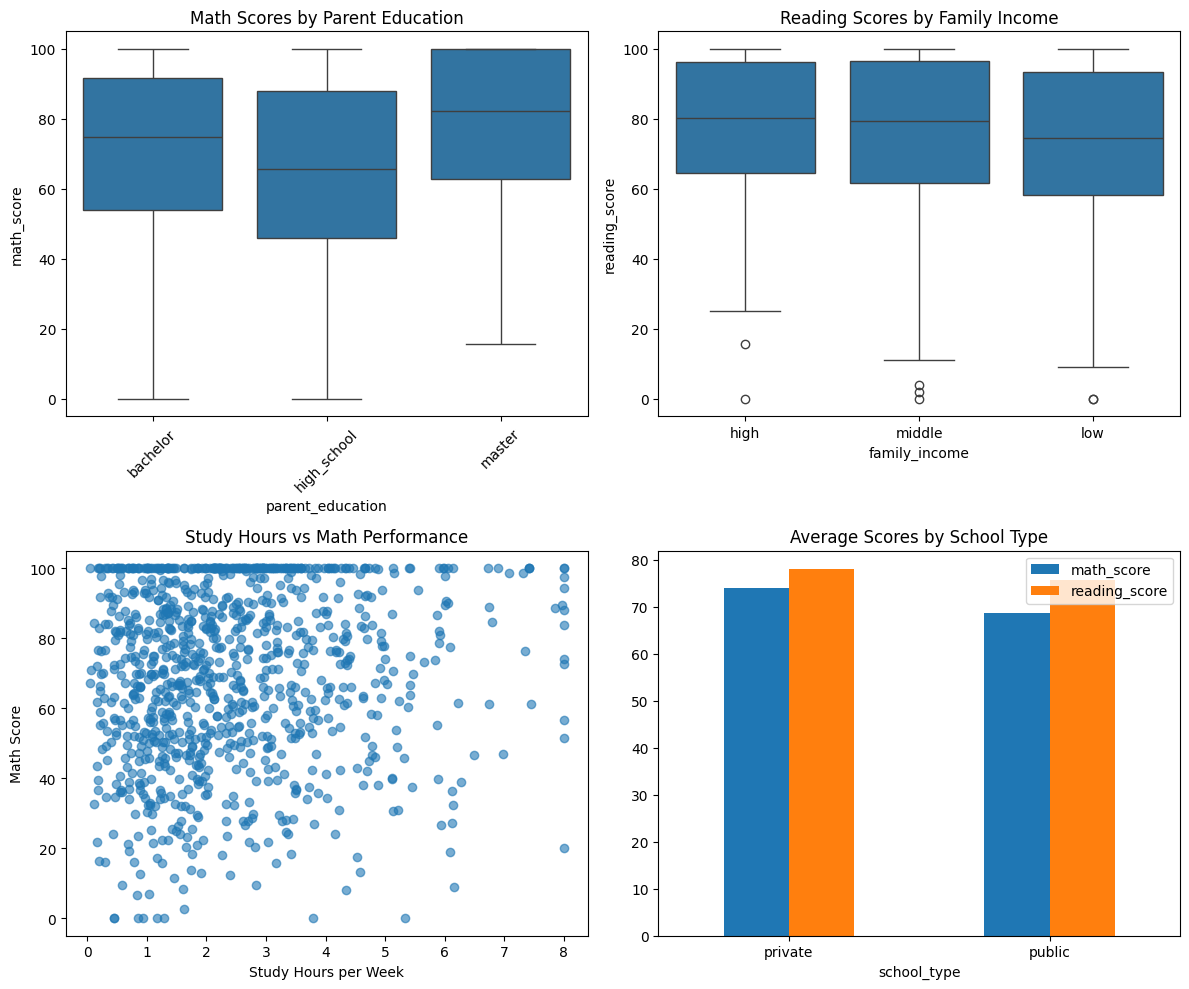

In [18]:
# some visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# math scores by parent education
sns.boxplot(data=df, x="parent_education", y="math_score", ax=axes[0,0])
axes[0,0].set_title("Math Scores by Parent Education")
axes[0,0].tick_params(axis="x", rotation=45)

# reading scores by family income
sns.boxplot(data=df, x="family_income", y="reading_score", ax=axes[0,1])
axes[0,1].set_title("Reading Scores by Family Income")

# study hours vs math score
axes[1,0].scatter(df["study_hours"], df["math_score"], alpha=0.6)
axes[1,0].set_xlabel("Study Hours per Week")
axes[1,0].set_ylabel("Math Score")
axes[1,0].set_title("Study Hours vs Math Performance")

# school type comparison
school_comparison = df.groupby("school_type")[["math_score", "reading_score"]].mean()
school_comparison.plot(kind="bar", ax=axes[1,1])
axes[1,1].set_title("Average Scores by School Type")
axes[1,1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

<h2 id="straightforward">2. Straightforward Generation 💥</h2>

This approach directly asks the LLM to analyze data patterns and generate hypotheses without additional context. The model examines the raw data sample and identifies potential relationships based on observed correlations. This represents the most basic form of hypothesis generation, relying solely on the LLM's ability to detect patterns in numerical and categorical data and serves as a baseline to compare against more sophisticated prompting techniques.

Since we generate hypotheses in a straightforward manner, we need nothing much as just a prompt.

In [19]:
from tqdm.notebook import tqdm

In [20]:
straightforward_template = """
You are a research scientist analyzing educational data. Below is a sample of student performance data with various demographic and behavioral variables:

==================
{data_sample}
==================

Based on this data, propose hypotheses that could explain patterns in student academic performance (math_score and reading_score). \
The hypotheses should describe all observed correlations and contradictions. Suggest 3-5 hypotheses. \
The hypotheses should describe potential causal relationships between the factors in the data and the academic performance scores: \
"If X, then the scores are generally higher/lower because Y."
"""

In [ ]:
results_straightforward = {}
for sample_size in tqdm([25, 100, 250]):
    data_sample = df.sample(sample_size).to_string(index=False)  # sample without index for better readability
    # generate hypotheses
    hypotheses = s_llm.invoke(straightforward_template.format(data_sample=data_sample))
    # store the results
    results_straightforward[sample_size] = hypotheses

  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
def print_hypotheses(hypotheses: dict):
    for sample_size, hyp in hypotheses.items():
        print(f"Sample Size: {sample_size}")
        print(hyp)
        print("\n" + "=" * 50 + "\n")

In [ ]:
print_hypotheses(results_straightforward)

Sample Size: 25
If students have higher attendance rates (e.g., above 90%), then their math and reading scores are generally higher because consistent attendance ensures they receive all instructional content and participate in classroom activities. (Confidence: 0.8)
If students come from families with higher parental education (e.g., bachelor's degree or higher), then their math and reading scores are generally higher because parental education level is associated with greater access to educational resources and higher expectations for academic success. (Confidence: 0.7)
If students attend schools with smaller class sizes (e.g., under 20 students), then their math and reading scores are generally higher because smaller classes allow for more individualized instruction and better teacher-student interaction. (Confidence: 0.6)
If students attend private schools, their reading scores are higher than public school peers, but math scores show no significant difference, possibly due to curr

<h2 id="lit">3. Literature-Conditioned Generation 📗</h2>

Here we provide the LLM with relevant research abstracts alongside the data to guide hypothesis generation -- basically, RAG on scientific material. This approach mimics how human researchers build upon existing knowledge when forming new hypotheses. The model can identify gaps in current literature, propose extensions to existing findings, or suggest novel research directions that complement established results.

Here, there is a single component to be added: namely, the literature fragments. Since RAG is not the focus of this lab, we will simulate extracted abstracts in a hard-code manner.

In [25]:
mock_literature = [
    {
        "title": "Socioeconomic Status and Academic Achievement: A Meta-Analysis",
        "abstract": "This meta-analysis of 142 studies (N = 582,696) examined the relationship between socioeconomic status (SES) and academic achievement. Results showed a moderate positive correlation (r = .31) between family income and standardized test scores. Parent education level was the strongest predictor of student achievement, with master's degree holders' children scoring 12-15 points higher on average than high school graduates' children. The effect was stronger for mathematics than reading comprehension."
    },
    {
        "title": "Private vs. Public Schools: Achievement Gaps and Class Size Effects",
        "abstract": "Analysis of 50,000 students across 500 schools revealed that private school students outperformed public school students by 8-12 points on standardized tests. However, when controlling for family income and parent education, the gap reduced to 3-5 points. Class size showed a negative correlation with achievement (r = -.23), with optimal class sizes between 15-20 students. The effect was more pronounced in mathematics than in language arts."
    },
    {
        "title": "The Role of Study Habits and Attendance in Academic Success",
        "abstract": "Longitudinal study of 1,200 high school students found that study hours per week correlated positively with GPA (r = .28). Students with less than 2 hours of weekly study time showed significantly lower performance across all subjects. Attendance rate was strongly correlated with achievement (r = .45), with students below 80% attendance showing marked declines in both mathematics and reading scores. The effects were cumulative and more pronounced over time."
    },
    # irrelevant literature
    {
        "title": "Urban-Rural Educational Disparities: Resource Access and Achievement",
        "abstract": "Comparative study of 10,000 students across urban, suburban, and rural districts found significant achievement gaps. Urban students had greater access to tutoring services (average 2.1 hours/week vs. 0.8 for rural students) and scored 6-8 points higher on standardized tests. However, rural students from highly educated families sometimes showed unexpected underperformance, suggesting resource constraints despite parental education. Suburban students consistently performed highest across all measures."
    },
    # literature about the contradictions: the expectation is, a new hypothesis will be generated with that
    {
    "title": "The Paradox of Low-Income, Highly Educated Families: When Parental Education Fails to Predict Achievement",
    "abstract": "This study of 15,000 students examined the relationship between parental education and academic achievement across different income levels. While the general trend shows positive correlations between parent education and student performance, we identified a concerning paradox: children from low-income families with master's educated parents showed significantly lower achievement than expected (effect size d = -0.42 for math, -0.35 for reading). Qualitative interviews revealed that financial stress combined with high parental expectations created performance anxiety and family tension. These families often lacked the financial resources to match their educational aspirations, leading to frustration and academic pressure that negatively impacted student outcomes. The findings suggest that parental education alone is insufficient when not accompanied by adequate economic resources."
    },
    {
        "title": "The Diminishing Returns of Academic Pressure: Over-Studying in Elite Educational Settings",
        "abstract": "Analysis of 8,500 private school students revealed an unexpected inverse relationship between excessive study time and academic performance. Students who reported more than 4 hours of daily study time showed decreased achievement compared to peers with moderate study schedules (2-3 hours), with a notable 6-8 point decline in standardized test scores. The phenomenon was particularly pronounced in competitive private school environments where academic pressure was highest. Longitudinal data indicated that over-studying led to burnout, decreased motivation, and paradoxically, less effective learning strategies. The study suggests an optimal study duration beyond which additional time becomes counterproductive, challenging the common assumption that more study time always leads to better outcomes. These findings highlight the importance of balanced academic approaches rather than intensive study regimens."
    }
]

In [27]:
literature_text = "\n\n".join([f"Title: {paper['title']}\nAbstract: {paper['abstract']}" for paper in mock_literature])
print(literature_text)

Title: Socioeconomic Status and Academic Achievement: A Meta-Analysis
Abstract: This meta-analysis of 142 studies (N = 582,696) examined the relationship between socioeconomic status (SES) and academic achievement. Results showed a moderate positive correlation (r = .31) between family income and standardized test scores. Parent education level was the strongest predictor of student achievement, with master's degree holders' children scoring 12-15 points higher on average than high school graduates' children. The effect was stronger for mathematics than reading comprehension.

Title: Private vs. Public Schools: Achievement Gaps and Class Size Effects
Abstract: Analysis of 50,000 students across 500 schools revealed that private school students outperformed public school students by 8-12 points on standardized tests. However, when controlling for family income and parent education, the gap reduced to 3-5 points. Class size showed a negative correlation with achievement (r = -.23), with 

In [28]:
literature_template = """
You are a research scientist analyzing educational data. Below is a sample of student performance data with various demographic and behavioral variables:

==================
{data_sample}
==================

Based on this data, propose hypotheses that could explain patterns in student academic performance (math_score and reading_score). \
The hypotheses should describe all observed correlations and contradictions. Suggest 3-5 hypotheses. \
The hypotheses should describe potential causal relationships between the factors in the data and the academic performance scores: \
"If X, then the scores are generally higher/lower because Y."


For that, you will be provided with relevant literature abstracts that may help you in hypothesis generation:

==================
{literature_text}
==================
"""

In [32]:
results_literature = {}
for sample_size in tqdm([25, 100, 250]):
    data_sample = df.sample(sample_size).to_string(index=False)  # sample without index for better readability
    # generate hypotheses
    hypotheses = s_llm.invoke(literature_template.format(data_sample=data_sample, literature_text=literature_text))
    # store the results
    results_literature[sample_size] = hypotheses

  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
print_hypotheses(results_literature)

Sample Size: 25
If students have attendance rates below 80%, then their math and reading scores are significantly lower because consistent school attendance is critical for maintaining learning continuity and participation in instructional activities. (Confidence: 0.9)
If students attend private schools with smaller class sizes (15-20 students), then their math and reading scores are generally higher because private schools often have more resources to maintain optimal class sizes, which allows for more individualized instruction. (Confidence: 0.85)
If students' parents have higher education levels (bachelor/master), then their math scores are significantly higher than those with less-educated parents because parental educational attainment strongly correlates with math-specific academic support and expectations. (Confidence: 0.85)
If students come from low-income families with highly educated parents (master's degree), then their math and reading scores are lower than expected because

### Interesting findings:
* The confidence is consistently better
* The contradictions are now (partially) found: `Hypothesis 5: Students in private schools studying more than 4 hours daily will have lower math scores than those with moderate study hours (2-3 hours) due to over-studying burnout and decreased learning efficiency in high-pressure environments. (Confidence: 0.75)` (250)
* Some new findings related to the contradictions now override some previous statements: `If students have higher study hours (study_hours > 5), then their math and reading scores are generally higher due to increased time spent on academic preparation and practice. (Confidence: 0.6)` from straightforward generation (250) vs `If students have study hours exceeding 4 hours daily, then their math and reading scores are lower due to burnout and ineffective learning strategies caused by excessive academic pressure. (Confidence: 0.75)` with literature (25)
* ...?

<h2 id="xdom">4. Cross-Domain Analogy Generation 🧬⚛️</h2>

This technique encourages the LLM to draw insights from other fields like economics, psychology, and biology to generate novel hypotheses about educational achievement. By thinking analogically, the model can apply successful patterns or principles from one domain to another, potentially uncovering innovative explanations. For example, the model might try to explain the effect through biological competition.

In [34]:
x_template = """
You are a research scientist analyzing educational data. Below is a sample of student performance data with various demographic and behavioral variables:

==================
{data_sample}
==================

Based on this data, propose hypotheses that could explain patterns in student academic performance (math_score and reading_score). \
The hypotheses should describe all observed correlations and contradictions. Suggest 3-5 hypotheses. \
The hypotheses should describe potential causal relationships between the factors in the data and the academic performance scores: \
"If X, then the scores are generally higher/lower because Y."

Consider patterns and principles from other domains that might apply to educational achievement.
For example, you can think about analogous patterns from these domains:
- Economics (market dynamics, resource allocation, investment returns)
- Biology (ecosystem dynamics, resource competition, adaptation)
- Business (performance optimization, resource management, team dynamics)
"""

In [35]:
results_x = {}
for sample_size in tqdm([25, 100, 250]):
    data_sample = df.sample(sample_size).to_string(index=False)  # sample without index for better readability
    # generate hypotheses
    hypotheses = s_llm.invoke(x_template.format(data_sample=data_sample))
    # store the results
    results_x[sample_size] = hypotheses

  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
print_hypotheses(results_x)

Sample Size: 25
Hypothesis 1: Students with higher parental education (e.g., bachelor's/master's degree) tend to have higher math and reading scores because parental education level correlates with greater access to educational resources and higher expectations, similar to how economic capital investment leads to better returns in market dynamics. (Confidence: 0.8)
Hypothesis 4: Students with consistent attendance (attendance_rate above 85%) show higher math scores due to less disruption in learning continuity, akin to ecosystem stability where consistent resource availability leads to better adaptation outcomes. (Confidence: 0.75)
Hypothesis 2: Students in private schools with smaller class sizes (e.g., under 20 students) perform better academically due to increased individualized attention, analogous to how smaller team sizes in business improve productivity through reduced competition for resources. (Confidence: 0.7)
Hypothesis 3: Higher family income levels correlate with better re

### Interesting findings:
* The confidence scores and the pattern to overlook contradictions remains the same
* The same effects as with straightforward generation are discovered, but they are now sometimes justified through analogies from other disciplines: `Hypothesis 4: Attendance rates (attendance_rate > 90%) strongly correlate with higher scores regardless of other factors, reflecting a foundational principle in system reliability—consistent participation ensures knowledge accumulation, akin to compound interest in economics where regular contributions lead to exponential growth. (Confidence: 0.9)` (250)
* ...?

<h2 id="contra">5. Contradiction-Based Generation ⁉️</h2>

This approach presents the LLM with contradictory or unexpected patterns in the data that challenge conventional assumptions. The model must then generate hypotheses that explain these anomalies, often revealing hidden mediating variables or contextual factors. This technique is particularly valuable for uncovering complex relationships that simple correlation analysis might miss.

In [36]:
# Create samples that highlight contradictions
low_income_bacherlors = df[(df["family_income"] == "low") & (df["parent_education"] == "bachelor")]
low_income_high_school = df[(df["family_income"] == "low") & (df["parent_education"] == "high_school")]
private_high_study = df[(df["school_type"] == "private") & (df["study_hours"] > 4)]
private_moderate_study = df[(df["school_type"] == "private") & (df["study_hours"] >= 2) & (df["study_hours"] <= 3)]

In [ ]:
contradictory_data = f"""
Low-income students with bachelors's educated parents:
---------------
{low_income_bacherlors.to_string(index=False)}


Low-income students with high school educated parents (for comparison):
---------------
{low_income_high_school.to_string(index=False)}


========================


Private school students with high study hours (>4 hours):
---------------
{private_high_study.to_string(index=False)}

Private school students with moderate study hours (2-3 hours, for comparison):
---------------
{private_moderate_study.to_string(index=False)}
"""

In [39]:
contra_template = """
You are a research scientist analyzing educational data. \
You've found some contradictory patterns that challenge common assumptions about educational achievement.

CONTRADICTORY PATTERNS IN THE DATA:
{contradictory_data}

These patterns seem to contradict typical expectations:
- Low-income students with highly educated parents sometimes perform worse than those with less educated parents
- Private school students who study more hours sometimes perform worse than those who study moderate amounts
- Some expected correlations don't hold in certain subgroups

Propose 3-5 hypotheses that could explain these contradictory findings. \
The hypotheses should describe potential causal relationships between the factors in the data and the academic performance scores: \
"If X, then the scores are generally higher/lower because Y."
"""

In [40]:
results_contra = s_llm.invoke(contra_template.format(contradictory_data=contradictory_data))

In [41]:
print(results_contra)

Moderate study hours in private schools allow balanced development. If study hours are optimized for focus and retention (2-3 hours), then scores could be higher due to effective time management. (Confidence: 0.8)
Low-income students with bachelor's-educated parents may experience higher expectations and pressure, leading to stress and lower performance in some cases. If parental pressure exceeds a student's coping capacity, then math/reading scores could be lower because of anxiety-induced underperformance. (Confidence: 0.7)
Private schools with high study hours might prioritize rote learning over critical thinking, causing diminished engagement. If excessive study hours focus on memorization without comprehension, then scores might drop due to lack of deep understanding. (Confidence: 0.65)
Highly educated parents in low-income households may have less time to assist due to work demands. If parental education level correlates with parental availability, then lower parental involvement

### Interesting findings:
* The model does explain the observed effects the way we did: `Low-income students with bachelor's-educated parents may experience higher expectations and pressure, leading to stress and lower performance in some cases. If parental pressure exceeds a student's coping capacity, then math/reading scores could be lower because of anxiety-induced underperformance. (Confidence: 0.7)`
* With that, some hypotheses are quite unexpected: `Private schools with high study hours might have stricter attendance policies that inadvertently penalize students. If excessive study hours lead to absenteeism or burnout, then lower attendance could cause score declines. (Confidence: 0.55)`
* ...?

<h2 id="iter">6. Iterative Refinement aka Mini-HypoGeniC 🔄</h2>

This method starts with a small data sample and progressively expands it while refining hypotheses across multiple iterations. Each iteration allows the model to test its previous hypotheses against new data and adjust or propose new ones accordingly.

At first, we will formulate the initial set of hypotheses with a smaller sample of data, then we will be refining the hypotheses while giving new portions of data. As the reward, we just will use the confidence the LLM generates itself.

In [42]:
template_iter = """
You are a research scientist in iteration {iteration} of hypothesis generation. \
You have already generated some hypotheses based on previous data samples:

=========================
{previous_hypotheses}
=========================


Your task now is to refine these hypotheses based on a new data sample if needed,
or propose new hypotheses if the previous ones do not hold. \

Data sample for this iteration:
=========================
{data_sample}
=========================


The hypotheses should describe all observed correlations and contradictions not covered by the previous hypotheses. \
The hypotheses should describe potential causal relationships between the factors in the data and the academic performance scores: \
"If X, then the scores are generally higher/lower because Y."
"""

In [52]:
def iterative_hypothesis_refinement(df, initial_sample_size=50, portion_size=25, iterations=10, max_hypotheses=10):

    results_iter = {}
    deleted_iter = {}

    # to avoid intersection when sampling, we'll shuffle the DataFrame
    # beforehand and then iterate over it
    df_shuffled = df.sample(frac=1)
    
    # initial hypotheses will be generated in the straightforward way
    initial_sample = df_shuffled[:initial_sample_size]
    initial_hypotheses = s_llm.invoke(
        straightforward_template.format(data_sample=initial_sample.to_string(index=False))
    )

    results_iter[0] = initial_hypotheses.hypotheses

    # iterate to refine hypotheses
    for i in tqdm(range(1, iterations + 1)):
    
        new_sample_start = initial_sample_size + (i - 1) * portion_size
        new_sample_end = new_sample_start + portion_size
        new_sample = df_shuffled[new_sample_start:new_sample_end]
        new_hypotheses = s_llm.invoke(
            template_iter.format(
                iteration=i,
                previous_hypotheses=results_iter[i - 1],
                data_sample=new_sample.to_string(index=False)
            )
        )

        results_iter[i] = results_iter[i - 1] + new_hypotheses.hypotheses
        results_iter[i] = sorted(results_iter[i], key=lambda x: x.confidence, reverse=True)
        if len(results_iter[i]) > max_hypotheses:
            to_delete = results_iter[i][max_hypotheses:]
            deleted_iter[i] = to_delete
            results_iter[i] = results_iter[i][:max_hypotheses]

    return results_iter, deleted_iter

In [53]:
results_iter, deleted_iter = iterative_hypothesis_refinement(df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
for i in range(len(results_iter)):
    print(f"Iteration {i}:")
    print("\n".join([f"{hypothesis.statement} (Confidence: {hypothesis.confidence})" for hypothesis in results_iter[i]]))
    print("\n" + "=" * 50 + "\n")
    if i in deleted_iter and deleted_iter[i]:
        print("Deleted hypotheses in this iteration:")
        print("\n".join([f"{hypothesis.statement} (Confidence: {hypothesis.confidence})" for hypothesis in deleted_iter[i]]))
        print("\n" + "-" * 50 + "\n")

Iteration 0:
Hypothesis 1: Students from families with higher parent education levels (e.g., bachelor's or master's degrees) tend to have higher math and reading scores compared to those with parents who only have a high school education. This is because higher parental education often correlates with greater access to educational resources and higher expectations for academic success. (Confidence: 0.8)
Hypothesis 2: Students attending schools with smaller class sizes (e.g., under 20 students) generally perform better academically than those in larger classes. Smaller class sizes allow for more individualized attention, leading to improved learning outcomes. (Confidence: 0.7)
Hypothesis 3: Higher family income levels correlate with higher academic scores due to the ability to afford tutoring, better learning materials, and possibly higher-quality schools. However, this may not hold true for all income brackets, as some low-income students with high parental education or strong study ha